https://github.com/LabForComputationalVision/universal_inverse_problem

Colab version of:
https://github.com/LabForComputationalVision/universal_inverse_problem/blob/master/Demo.ipynb

In [1]:
# Instalar el github
!git clone "https://github.com/LabForComputationalVision/universal_inverse_problem.git"


fatal: destination path 'universal_inverse_problem' already exists and is not an empty directory.


In [2]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'universal_inverse_problem/code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *


os.chdir('universal_inverse_problem')

%matplotlib inline

In [3]:
os.getcwd()

'/content/universal_inverse_problem'

1. Denoiser architecture

In [4]:
# Print a list of pre-trained denoiser architectures
print( os.listdir('denoisers'))

# Choose an architecture from the list
architecture = 'BF_CNN'

['BF_CNN']


2. Training dataset

In [5]:
# Print a list of training datasets associated with the architecture
print(os.listdir(os.path.join('denoisers',architecture)))

# Choose a trainig set:
training_data = 'BSD300_color'

if 'color' in training_data.split('_'):
    grayscale = False # number of input and output channels is 3
    C = 3
else:
    grayscale = True # number of input and output channels is 1
    C = 1

['BSD400_gray', 'BSD300_color', 'mnist_gray']


In [6]:
# Now, choose the range of noise used during training from the list below
print(os.listdir(os.path.join('denoisers',architecture,training_data)))

training_noise='noise_range_0to100'

['noise_range_0to100']


In [7]:
denoiser = load_denoiser(architecture=architecture,
                         grayscale=grayscale,
                         training_data=training_data,
                         training_noise=training_noise)

denoiser.eval();

# Image synthesis



----------------------------- 5
sigma  0.9424538612365723
----------------------------- 10
sigma  0.8080423474311829
----------------------------- 15
sigma  0.6098237633705139
----------------------------- 20
sigma  0.41359013319015503
----------------------------- 25
sigma  0.2568897008895874
----------------------------- 30
sigma  0.14643721282482147
----------------------------- 35
sigma  0.07451365143060684
----------------------------- 40
sigma  0.03337584808468819
----------------------------- 45
sigma  0.012445162050426006
-------- total number of iterations,  47
-------- average time per iteration (s),  0.0632
value range 0.23 0.63


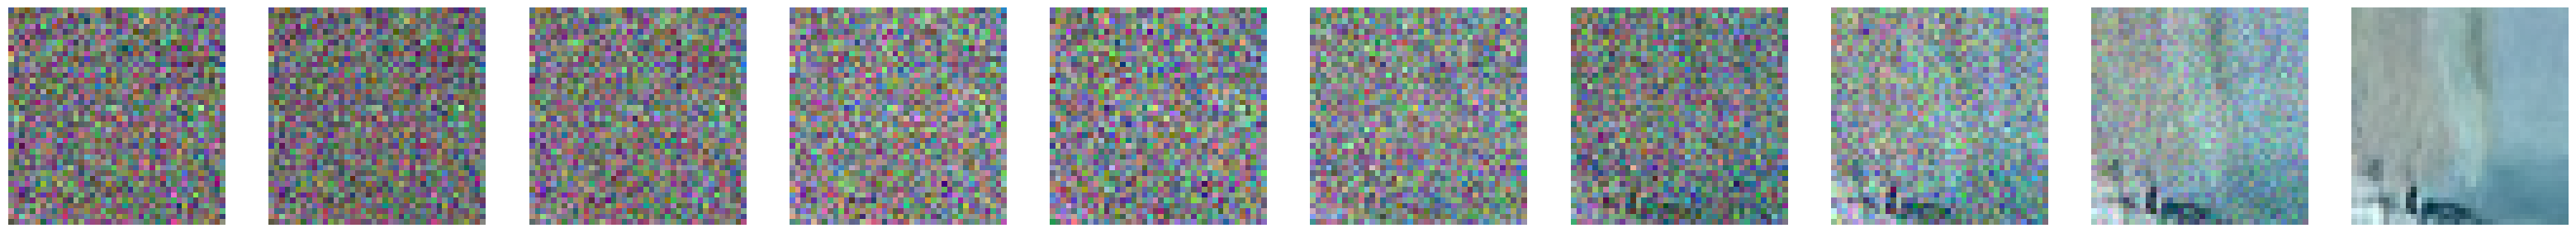

In [9]:
# choose the size of the sample patch:
patch_size = (C,40,40) #choose 28x28 for mnist patch size
x_c = torch.zeros(patch_size)
if torch.cuda.is_available():
    x = x.cuda()

synth = synthesis()
sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = x_c,
                                 task = synth,
                                 sig_0 = 1,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.5,  # change beta to see how quality of generated samples change
                                 freq = 5)

## plot the progression and the final sample
plot_synthesis(interm_Ys, sample)

# Inverse problems

In [10]:
# Choose a test dataset
# Note: grayscale/color of the test images must be consistent with grayscale/color of denoiser training data
if grayscale is True:
    path = 'test_images/grayscale/'
else:
    path = 'test_images/color/'
print('Test datasets: ', os.listdir(path))

test_folder = 'Set14'

Test datasets:  ['BSD100', 'Set5', 'Set14']


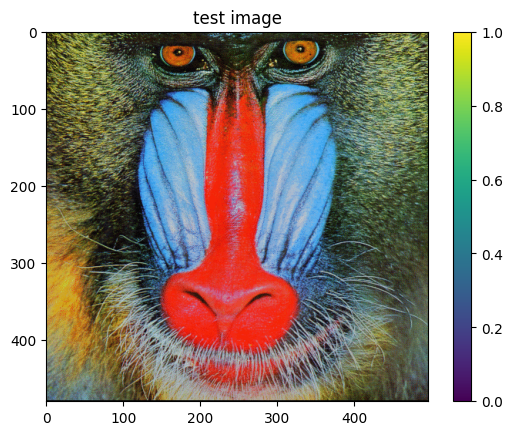

In [19]:
# choose an image number
im_num = 3

X = test_image(grayscale, path+test_folder+'/', im_num)
X.show()

In [18]:
X

torch.Size([3, 60, 60])

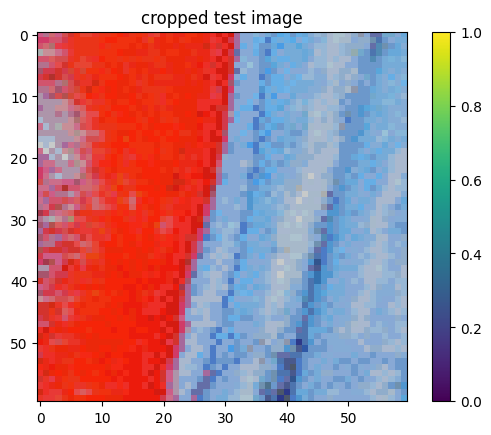

In [20]:
# crop a portion of the image (smaller will run faster)
x = X.crop(210,250,60,60)
x.shape

1. Inpainting

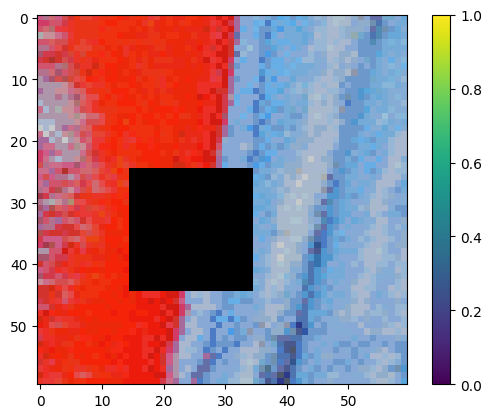

In [21]:
# Specify top-left corner and size of "hole" to be inpainted (filled in) ***
inpaint = inpainting(x_size=x.size(), y0=25, x0=35, h=20, w=20)

plot_corrupted_im(inpaint.M(inpaint.M_T(x)))

----------------------------- 40
sigma  0.9402399063110352
----------------------------- 80
sigma  0.7771149277687073
----------------------------- 120
sigma  0.6123543381690979
----------------------------- 160
sigma  0.49070414900779724
----------------------------- 200
sigma  0.38711586594581604
----------------------------- 240
sigma  0.25915077328681946
----------------------------- 280
sigma  0.18360573053359985
----------------------------- 320
sigma  0.11284969747066498
----------------------------- 360
sigma  0.07051952183246613
----------------------------- 400
sigma  0.023497657850384712
-------- total number of iterations,  424
-------- average time per iteration (s),  0.1396


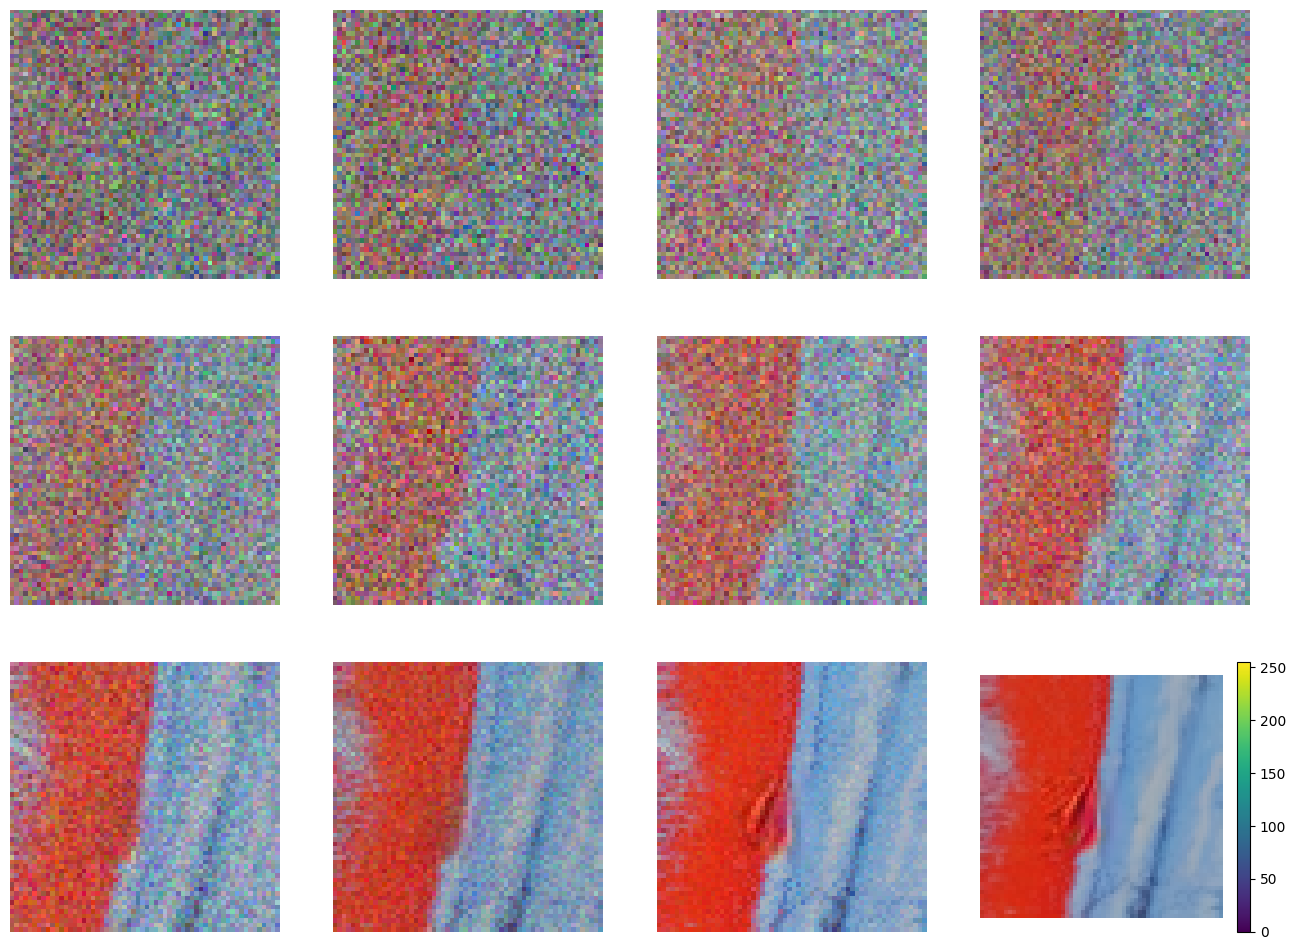

In [22]:
# In solving linear inverse problems, in order to get good quality samples, beta should be small, that is lots of
# added noise in each iteration.
# This gives the algorithm the freedom to explore the space and arrive at a point on the manifold where the
# linear constraint is satisfied

sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = inpaint.M_T(x),
                                 task = inpaint,
                                 sig_0 = 1,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.01,
                                 freq = 40)
plot_all_samples(sample, interm_Ys)

/content/universal_inverse_problem/code/Utils_inverse_prob.py:203: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = np.round(structural_similarity(x.numpy(), corrupted.numpy(), multichannel=True  ) ,3 )
/content/universal_inverse_problem/code/Utils_inverse_prob.py:208: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = np.round(structural_similarity(x.numpy(), sample.numpy() , multichannel=True) ,3)


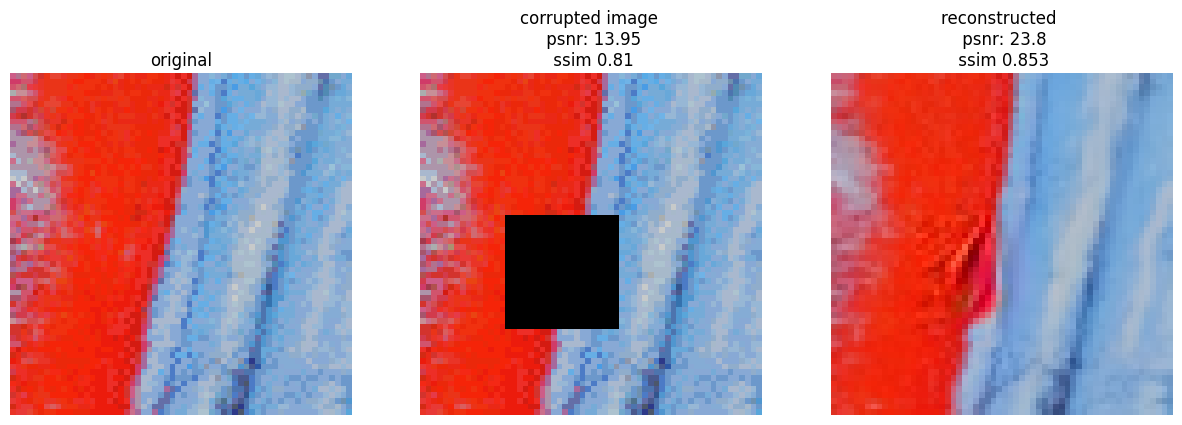

In [23]:
plot_sample(x, inpaint.M(inpaint.M_T(x)), sample)

2. Missing random pixels

*** Retained 2160 / 10800 (20.0%) of dimensions
----------------------------- 40
sigma  0.896308183670044
----------------------------- 80
sigma  0.6681755185127258
----------------------------- 120
sigma  0.43987762928009033
----------------------------- 160
sigma  0.2796023190021515
----------------------------- 200
sigma  0.1452355980873108
----------------------------- 240
sigma  0.013213158585131168
-------- total number of iterations,  243
-------- average time per iteration (s),  0.1459


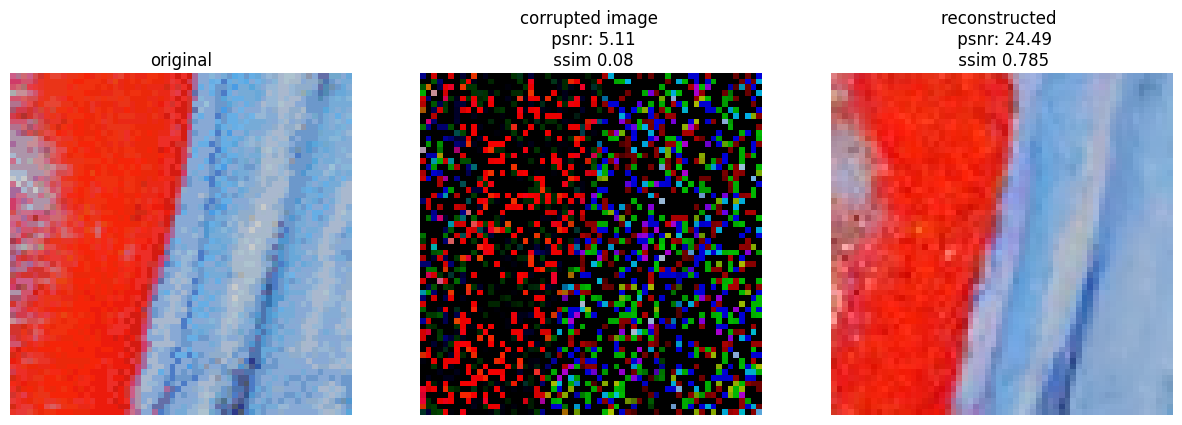

In [24]:
# Retain a random subset of pixels.
rand_pix = rand_pixels(x_size = x.size(), p = 0.2) # p = fraction of pixels kept

print_dim(measurment_dim=rand_pix.mask.sum().item(), image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = rand_pix.M_T(x),
                                 task = rand_pix,
                                 sig_0 = 1 ,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.01,
                                 freq = 40)

plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

3. Super resolution

*** Retained 675 / 10800 (6.25%) of dimensions
----------------------------- 40
sigma  0.9261229038238525
----------------------------- 80
sigma  0.7814731597900391
----------------------------- 120
sigma  0.5782960057258606
----------------------------- 160
sigma  0.3869822025299072
----------------------------- 200
sigma  0.2576518654823303
----------------------------- 240
sigma  0.1113467812538147
-------- total number of iterations,  266
-------- average time per iteration (s),  0.1402


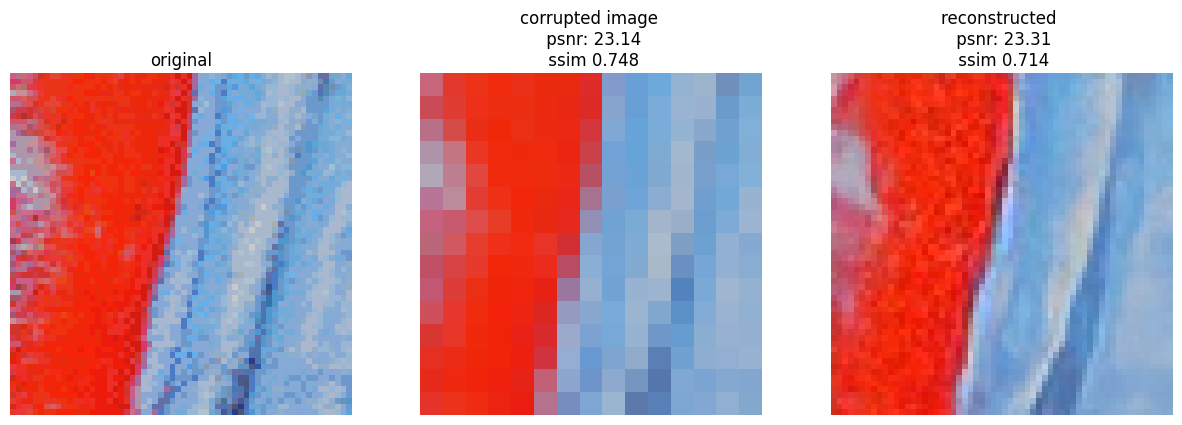

In [25]:
# Subsample image by factor of s (both horizontally and vertially)
super_res = super_resolution(x_size=x.size(), s = 4)

print_dim(measurment_dim=np.prod(super_res.M_T(x).shape), image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser,
                                  x_c = super_res.M_T(x),
                                  task = super_res,
                                  sig_0 = 1 ,
                                  sig_L = 0.01,
                                  h0 = 0.01,
                                  beta = 0.01,
                                  freq = 40)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

4. Random basis

/content/universal_inverse_problem/code/Utils_inverse_prob.py:375: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2426.)
  self.U, _ = torch.qr(torch.randn(int(np.prod(x_size)),int(np.prod(x_size)*p) ))


*** Retained 2160 / 10800 (20.0%) of dimensions
----------------------------- 40
sigma  0.8787400126457214
----------------------------- 80
sigma  0.6279093623161316
----------------------------- 120
sigma  0.44712144136428833
----------------------------- 160
sigma  0.29883137345314026
----------------------------- 200
sigma  0.15918280184268951
----------------------------- 240
sigma  0.03903474658727646
-------- total number of iterations,  251
-------- average time per iteration (s),  0.1783


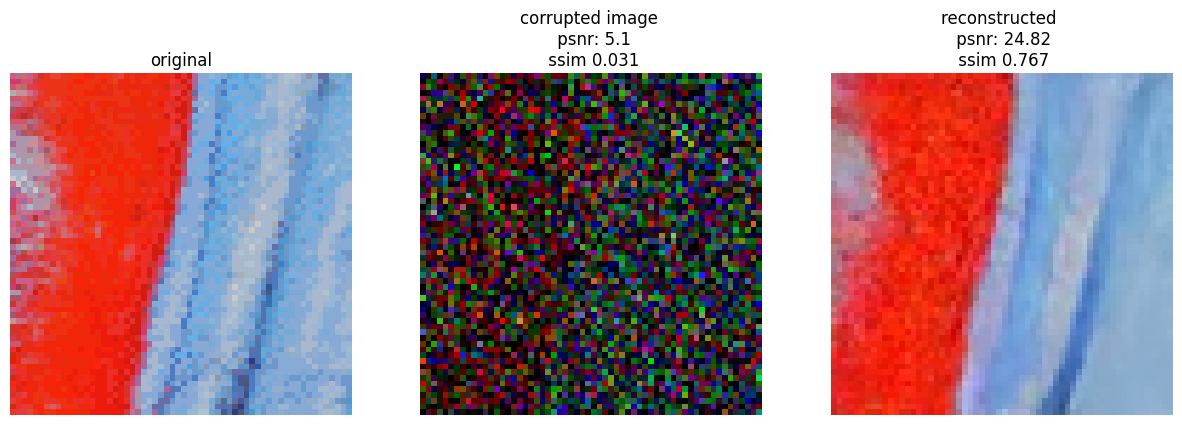

In [26]:
# Project image onto a random set of basis functions
rand_basis = random_basis(x_size = x.shape , p = 0.2) # p = fraction of dimensions kept

print_dim(measurment_dim=rand_basis.U.shape[1], image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = rand_basis.M_T(x),
                                 task = rand_basis,
                                 sig_0 = 1,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = .01,
                                 freq = 40)

plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

5. Spectral super resolution

*** Retained 2028 / 10800 (18.778%) of dimensions
----------------------------- 40
sigma  0.9808374643325806
----------------------------- 80
sigma  0.8328979015350342
----------------------------- 120
sigma  0.6377004981040955
----------------------------- 160
sigma  0.4798170328140259
----------------------------- 200
sigma  0.333753764629364
----------------------------- 240
sigma  0.2239406257867813
----------------------------- 280
sigma  0.11127982288599014
-------- total number of iterations,  314
-------- average time per iteration (s),  0.1352


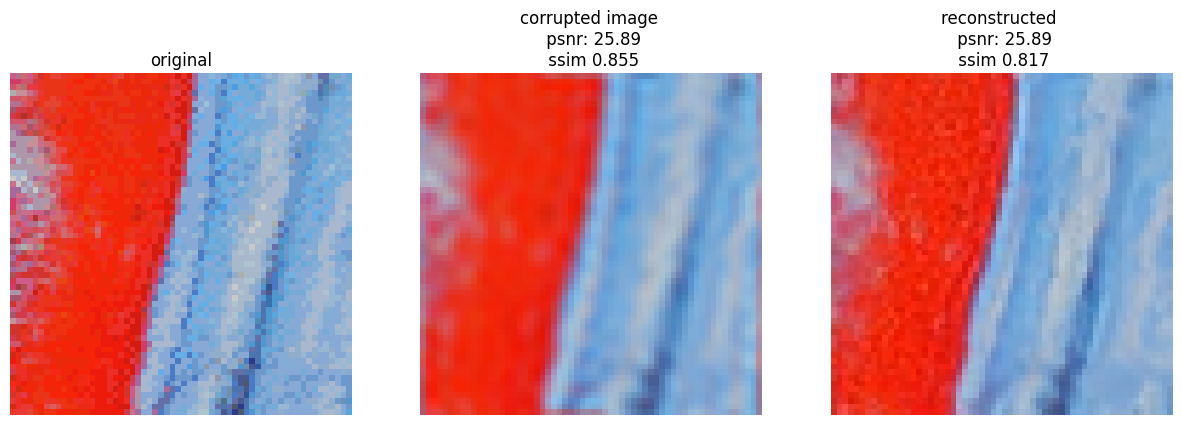

In [27]:
# Project onto low frequencies (a subset of the Fourier basis)
spec_super_res = spectral_super_resolution(x_size= x.size(), p = 0.2) # p=fraction of low frequencies kept

print_dim(measurment_dim=spec_super_res.mask.sum()*C, image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser,
                                  x_c=spec_super_res.M_T(x),
                                  task = spec_super_res,
                                  sig_0=1 ,
                                  sig_L=.01,
                                  h0=.01,
                                  beta = 0.01,
                                  freq = 40)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)